# Using USR to score dialogues

In [13]:
import sys
import os
import sys
import os
import emissor as em
from emissor.persistence import ScenarioStorage
from emissor.representation.annotation import AnnotationType, Token, NER
from emissor.representation.container import Index
from emissor.representation.scenario import Modality, ImageSignal, TextSignal, Mention, Annotation, Scenario

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

#### The next utils are needed for the interaction and creating triples and capsules
import chatbots.evaluation as eval
from chatbots.evaluation.dialogue_evaluation_likelihood import USR_MLM
from chatbots.evaluation.dialogue_evaluation_usr import USR_CTX

In [14]:
def get_turns_with_context_from_signals(signals:[], max_context=200):
    triples = []
    context = ""
    target = ""
    cue =""
    for index, signal in enumerate(signals):
        if index == 0:
            target = ''.join(signal.seq)
        else:
            cue = target
            context += " "+target
            target = ''.join(signal.seq)
        if len(context)>max_context:
            context = context[len(context)-max_context:]
        triple = (context, target, cue)
        triples.append(triple)
    return triples

In [19]:
scenario_path = "/Users/piek/PycharmProjects/cltl-chatbots/data"
### The name of your scenario
scenario_id = "2021-11-30-09:08:06"

max_context=300
### Create the scenario folder, the json files and a scenarioStorage and scenario in memory
scenarioStorage = ScenarioStorage(scenario_path)
scenario_ctrl = scenarioStorage.load_scenario(scenario_id)
signals = scenario_ctrl.get_signals(Modality.TEXT)
turns = get_turns_with_context_from_signals(signals, max_context)
print('Nr of turns:', len(turns), ' extracted from scenario: ', scenario_id)

Nr of turns: 62  extracted from scenario:  2021-11-30-09:08:06


In [ ]:
top=20
model_path_mlm = 'adamlin/usr-topicalchat-roberta_ft'
model_mlm = USR_MLM(path=model_path_mlm, top_results=top)

In [24]:
scores = []
max_scores=[]
odd_scores=[]
odd_max_scores=[]
even_scores=[]
even_max_scores=[]
turn_index =[]
for index, turn in enumerate(turns):
    turn_index.append(index)
    context = turn[0]
    target = turn[1]
    cue=turn[2]
    llh, best_sentence, max_score = model_mlm.sentence_likelihood(context,target)
    print('Turn:', index)
    print('Input:', cue)
    print('Response', target)
    print('\tLikelihood:', llh)
    print('Best model response', best_sentence)
    print('\tMax score:', max_score)
    scores.append(llh)
    max_scores.append(max_score)

    if index % 2 == 0:
        even_scores.append(llh)
        even_max_scores.append(max_score)
    else:
        odd_scores.append(llh)
        odd_max_scores.append(max_score)

Turn: 0
Input: 
Response Let's chat!
	Likelihood: 0.0
Best model response  great  go 
	Max score: 0.5169524326920509
Turn: 1
Input: Let's chat!
Response I'm on mobile, but I'll PM you.
	Likelihood: 0.11136879452637263
Best model response  maybe  not  vacation  but  what  see  you 
	Max score: 0.37057574306215557
Turn: 2
Input: I'm on mobile, but I'll PM you.
Response Interesting
	Likelihood: 0.0
Best model response  :) 
	Max score: 0.4150792956352234
Turn: 3
Input: Interesting
Response I'm on mobile, but I'll PM you.
	Likelihood: 0.28560354879924227
Best model response 'm  on  mobile  but  will  tell  you 
	Max score: 0.817691051534244
Turn: 4
Input: I'm on mobile, but I'll PM you.
Response Good to know
	Likelihood: 0.6863426864147186
Best model response good  to  hear 
	Max score: 0.6942211588223776
Turn: 5
Input: Good to know
Response I'm on mobile, but I'll PM you.
	Likelihood: 0.3436145399297987
Best model response  your  on  mobile  but  i  PM  you 
	Max score: 0.7583223283290863


In [38]:
average_score = sum(scores)/len(scores)
print('\nAverage score:', average_score)
#print('Sequence profile:', scores)

average_max_score = sum(max_scores)/len(max_scores)
print('\nAverage max score:', average_max_score)
#print('Sequence max profile:', max_scores)

average_even_score = sum(even_scores) / len(even_scores)
print('\nAverage even score:', average_even_score)
#print('Even sequence profile:', even_scores)

average_max_even_score = sum(odd_max_scores) / len(even_max_scores)
print('\nAverage max even score:', average_max_score)
#print('Max even sequence max profile:', even_max_scores)

average_odd_score = sum(odd_scores) / len(odd_scores)
print('\nAverage odd score:', average_odd_score)
#print('Odd sequence profile:', odd_scores)

average_max_odd_score = sum(odd_max_scores) / len(odd_max_scores)
print('\nAverage max odd score:', average_max_odd_score)
#print('Max odd sequence max profile:', odd_max_scores)


Average score: 0.4150999247524367

Average max score: 0.702066111717279

Average even score: 0.35726288844792575

Average max even score: 0.702066111717279

Average odd score: 0.47293696105694794

Average max odd score: 0.7624924522745903


In [25]:
import numpy as np
import matplotlib.pyplot as plt

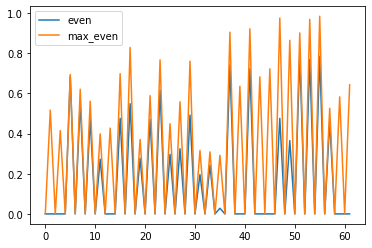

In [35]:
even_scores_graph = []
for s in even_scores:
    even_scores_graph.append(0)
    even_scores_graph.append(s)

max_even_scores_graph = []
for s in even_max_scores:
    max_even_scores_graph.append(0)
    max_even_scores_graph.append(s)

plt.plot(turn_index, even_scores_graph, label="even")
plt.plot(turn_index, max_even_scores_graph, label="max_even")

plt.legend()

62 62 62


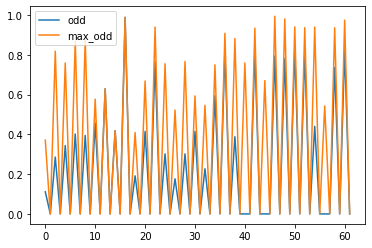

In [34]:

odd_scores_graph = []
for s in odd_scores:
    odd_scores_graph.append(s)
    odd_scores_graph.append(0)

max_odd_scores_graph = []
for s in odd_max_scores:
    max_odd_scores_graph.append(s)
    max_odd_scores_graph.append(0)

plt.plot(turn_index, odd_scores_graph, label="odd")
plt.plot(turn_index, max_odd_scores_graph, label="max_odd")
plt.legend()

## End of notebook